In [12]:
import pandas as pd
import nltk
import unicodedata
import re
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Load DataFrame
df = pd.read_csv("../data/pdf_metadata_and_summaries.csv")  # Replace with your actual filename

In [4]:
df.columns

Index(['File Name', 'Metadata', 'Summary'], dtype='object')

In [5]:
ADDITIONAL_STOPWORDS = ['bank', 'fdic', 'institution']

# Function to clean the sentence and return a list of cleaned words
def clean(sentence):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords_list = stopwords.words('english') + ADDITIONAL_STOPWORDS
    sentence = (unicodedata.normalize('NFKD', sentence)
                .encode('ascii', 'ignore')
                .decode('utf-8', 'ignore')
                .lower())
    
    # Remove numbers, punctuations, and any word with a single letter
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)  # Keep only alphabetic characters and spaces
    words = sentence.split()
    
    # Lemmatize and filter out stopwords and single-letter words
    word_list = [wnl.lemmatize(word) for word in words if len(word) > 1 and word not in stopwords_list]
    
    return word_list

# Function to get a list of lists of cleaned words from a dataframe column
def get_words(df, column):
    """
    Takes a dataframe and a column and returns a list of
    lists of cleaned words that are returned by clean().

            Parameters:
                    df (dataframe): A pandas dataframe
                    column (str): A column name in the dataframe

            Returns:
                    list of lists: A list where each element is a list of cleaned words for each document
    """
    # Apply clean() to each row in the specified column
    return [clean(str(text)) for text in df[column]]

In [6]:
all_words = get_words(df, 'Summary')

In [7]:
type(all_words)

list

In [8]:
len(all_words)

98

In [9]:
all_words[0]

['february',
 'report',
 'aud',
 'material',
 'loss',
 'review',
 'first',
 'priority',
 'bradenton',
 'florida',
 'audit',
 'report',
 'report',
 'aud',
 'february',
 'material',
 'loss',
 'review',
 'first',
 'priority',
 'bradenton',
 'florida',
 'audit',
 'result',
 'fpb',
 'failed',
 'primarily',
 'due',
 'management',
 'aggressive',
 'pursuit',
 'asset',
 'growth',
 'concentrated',
 'highrisk',
 'cre',
 'loan',
 'inadequate',
 'loan',
 'underwriting',
 'lack',
 'loan',
 'portfolio',
 'risk',
 'management',
 'control',
 'resulting',
 'loss',
 'severely',
 'eroded',
 'fpbs',
 'earnings',
 'capital',
 'negatively',
 'impacted',
 'liquidity',
 'leading',
 'bank',
 'failure',
 'material',
 'loss',
 'dif',
 'management',
 'fpbs',
 'board',
 'director',
 'bod',
 'ensure',
 'management',
 'identified',
 'measured',
 'monitored',
 'controlled',
 'risk',
 'institution',
 'activity',
 'addition',
 'bod',
 'ensure',
 'corrective',
 'action',
 'implemented',
 'response',
 'examiner',
 'audito

In [10]:
# Create a dictionary from the tokenized texts
dictionary = corpora.Dictionary(all_words)

# Create a corpus: a list of bag-of-words for each document
corpus = [dictionary.doc2bow(word) for word in all_words]

In [11]:
# Apply LDA model (number of topics is 4 here, you can adjust it)
lda_model = LdaModel(corpus, num_topics=4, id2word=dictionary, passes=15)

# Print the topics
topics = lda_model.print_topics(num_words=5)  # num_words shows top words in each topic
for topic in topics:
    print(topic)

(0, '0.017*"loan" + 0.012*"examination" + 0.011*"risk" + 0.011*"management" + 0.010*"capital"')
(1, '0.025*"loan" + 0.014*"management" + 0.014*"bank" + 0.014*"examination" + 0.011*"risk"')
(2, '0.021*"loan" + 0.014*"examination" + 0.012*"report" + 0.012*"management" + 0.012*"risk"')
(3, '0.013*"bank" + 0.013*"management" + 0.012*"first" + 0.011*"loan" + 0.010*"examination"')


In [13]:
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=10, step=1):
    """
    Compute coherence scores for different numbers of topics.

    Parameters:
        dictionary (gensim.corpora.Dictionary): Gensim dictionary.
        corpus (list): Gensim corpus.
        texts (list of list of str): Tokenized texts.
        start (int): Minimum number of topics.
        limit (int): Maximum number of topics.
        step (int): Step size for topics.

    Returns:
        model_list (list): List of LDA topic models.
        coherence_values (list): Coherence values corresponding to the LDA models.
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=493)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Text(0.5, 0, 'Number of Topics')

Text(0, 0.5, 'Coherence Score')

Text(0.5, 1.0, 'Coherence Score vs Number of Topics')

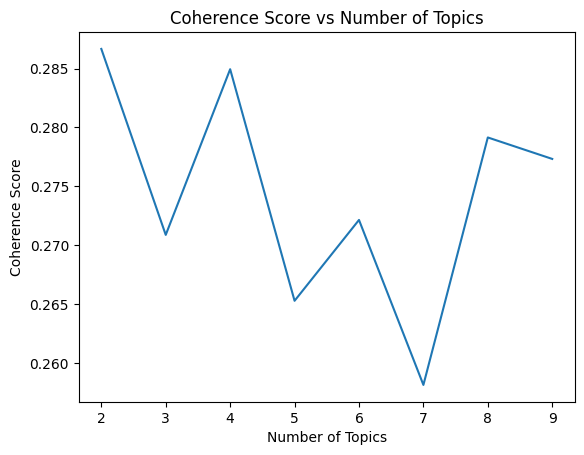

In [15]:
# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary, corpus, all_words, start=2, limit=10, step=1)

# Plot coherence values
x = range(2, 10, 1)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

In [16]:
for num_topics in range(2, 10, 1):
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=493)
    print(f"Num Topics: {num_topics}, Perplexity: {model.log_perplexity(corpus)}")


Num Topics: 2, Perplexity: -6.961970404328083
Num Topics: 3, Perplexity: -6.954316827475365
Num Topics: 4, Perplexity: -6.940907743033147
Num Topics: 5, Perplexity: -6.93342267115195
Num Topics: 6, Perplexity: -6.938340717148338
Num Topics: 7, Perplexity: -6.934011681464481
Num Topics: 8, Perplexity: -6.932007735837808
Num Topics: 9, Perplexity: -6.925158061229306


In [19]:
import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display

# Display visualization inline in Jupyter Notebook
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary, sort_topics=False)
display(lda_display)



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.049526  0.067853       1        1   6.759526
1     -0.008751 -0.005751       2        1  18.976971
2      0.005214 -0.017089       3        1  16.591559
3     -0.004685 -0.014917       4        1  13.734522
4     -0.010748 -0.005479       5        1  12.002762
5     -0.008319 -0.020645       6        1  17.040722
6      0.090381  0.029292       7        1   0.690226
7     -0.013566 -0.033264       8        1  14.203712, topic_info=                           Term          Freq         Total Category  logprob  \
726                        loan  13504.000000  13504.000000  Default  30.0000   
294                         cre   3227.000000   3227.000000  Default  29.0000   
661                 institution   4983.000000   4983.000000  Default  28.0000   
1084                       risk   7363.000000   7363.000000  Default  27.0000   
127                        bank   7610.000000   7610.000000  Default  26.0000   
340                     deposit   4177.000000   4177.000000  Default  25.0000   
160                     capital   6191.000000   6191.000000  Default  24.0000   
1043                     report   6533.000000   6533.000000  Default  23.0000   
547                     funding   2464.000000   2464.000000  Default  22.0000   
513                   financial   4196.000000   4196.000000  Default  21.0000   
235               concentration   4350.000000   4350.000000  Default  20.0000   
451                 examination   8686.000000   8686.000000  Default  19.0000   
24                          adc   3588.000000   3588.000000  Default  18.0000   
732                        loss   5124.000000   5124.000000  Default  17.0000   
1151                     source   2236.000000   2236.000000  Default  16.0000   
6788                   republic    402.000000    402.000000  Default  15.0000   
516                       first   1556.000000   1556.000000  Default  14.0000   
243                   condition   2607.000000   2607.000000  Default  13.0000   
1106                    section   2086.000000   2086.000000  Default  12.0000   
807                     noncore   1005.000000   1005.000000  Default  11.0000   
163                 capitalized   1136.000000   1136.000000  Default  10.0000   
1211                supervisory   3921.000000   3921.000000  Default   9.0000   
1291                 visitation   1439.000000   1439.000000  Default   8.0000   
749                  management   8408.000000   8408.000000  Default   7.0000   
152                    brokered   1428.000000   1428.000000  Default   6.0000   
708                     lending   2536.000000   2536.000000  Default   5.0000   
1240                       time   1274.000000   1274.000000  Default   4.0000   
20                          act   1963.000000   1963.000000  Default   3.0000   
1109                   security   1039.000000   1039.000000  Default   2.0000   
1209                supervision   2205.000000   2205.000000  Default   1.0000   
6015                   affinity    207.543039    210.628650   Topic1  -5.3617   
6528               madisonville    106.831873    108.678274   Topic1  -6.0258   
6788                   republic    394.747535    402.275252   Topic1  -4.7188   
8438                       sbny     93.517544     95.346172   Topic1  -6.1589   
6515                       fbop     67.161924     68.588489   Topic1  -6.4900   
8439                      sbnys     66.245139     67.773675   Topic1  -6.5037   
8303                         sr     43.842727     45.234953   Topic1  -6.9165   
8360                    digital     36.420801     37.711013   Topic1  -7.1019   
8226                     cotton     41.225184     42.748286   Topic1  -6.9780   
6529              madisonvilles     29.887994     31.009545   Topic1  -7.2996   
6430                       aubs    109.664599    114.255152   Topic1  -5.9996   
6516           

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'Number of Clusters (Topics)')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'Optimal Number of Topics Using K-means and Silhouette Scores')

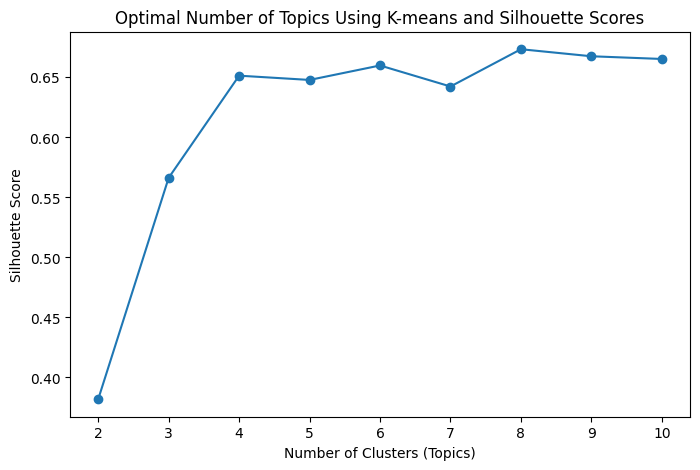

In [21]:
from gensim.models import LdaModel
from gensim import corpora
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Each document is represented as a vector of topic probabilities
doc_topic_matrix = np.array([dict(lda_model.get_document_topics(bow, minimum_probability=0)) 
                              for bow in corpus])

# Ensure a dense matrix with all probabilities for each topic
doc_topic_matrix = np.array([[doc.get(i, 0.0) for i in range(lda_model.num_topics)] for doc in doc_topic_matrix])

# Step 4: Apply K-means Clustering
def optimal_kmeans(doc_topic_matrix, max_clusters=10):
    silhouette_scores = []
    cluster_range = range(2, max_clusters + 1)
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(doc_topic_matrix)
        silhouette_avg = silhouette_score(doc_topic_matrix, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    return cluster_range, silhouette_scores

cluster_range, silhouette_scores = optimal_kmeans(doc_topic_matrix, max_clusters=10)

# Step 5: Plot the Results
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (Topics)")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Topics Using K-means and Silhouette Scores")
plt.show()